# Creating dummy data for Bayesian modeling
Here I create the dummy data

In [1]:
# imports
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

## Create dates

In [2]:
# Create a date range
date_range = pd.date_range(start='2024-01-01', end='2025-02-28', freq='D')
print(date_range)

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-22',
               '2025-02-23', '2025-02-24', '2025-02-25', '2025-02-26',
               '2025-02-27', '2025-02-28'],
              dtype='datetime64[ns]', length=425, freq='D')


## Get weather data

scrape google for weather data

In [3]:
# Define the URL
url = 'https://www.worldweatheronline.com/esch-sur-alzette-weather-averages/luxembourg/lu.aspx'

# Send a request to the website
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with class "table table-striped"
table = soup.find('table', class_='table table-striped')

# Print the table to verify
print(table)

<table class="table table-striped"><thead class="thead-dark"><tr><th scope="col">Month</th><th class="text-center" scope="col">Day</th><th class="text-center" scope="col">Night</th><th class="text-center" scope="col">Rain Days</th></tr></thead><tbody>
<tr><td>January</td><td class="text-center" style="background-color:#9BF6F3;">4°c</td><td class="text-center" style="background-color:#9BF6F3;">0°c</td>
<td class="text-center">10</td></tr><tr><td>February</td><td class="text-center" style="background-color:#A4F6E9;">6°c</td><td class="text-center" style="background-color:#9BF6F3;">0°c</td>
<td class="text-center">7</td></tr><tr><td>March</td><td class="text-center" style="background-color:#80F9CC;">10°c</td><td class="text-center" style="background-color:#9BF6F3;">2°c</td>
<td class="text-center">7</td></tr><tr><td>April</td><td class="text-center" style="background-color:#73F6AB;">14°c</td><td class="text-center" style="background-color:#9BF6F3;">4°c</td>
<td class="text-center">8</td><

In [4]:
columns = [header.text for header in table.find_all('th', scope='col')]

# Extract rows
rows = []
for row in table.find_all('tr')[1:]:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells]
    rows.append(row_data)

# Create DataFrame
scope_table_df = pd.DataFrame(rows, columns=columns)

format the scope_table_df

In [5]:
# Remove '°c' and convert to numbers
scope_table_df['Day'] = scope_table_df['Day'].str.replace('°c', '').astype(int)
scope_table_df['Night'] = scope_table_df['Night'].str.replace('°c', '').astype(int)

In [6]:
scope_table_df['Rain Days'] = scope_table_df['Rain Days'].astype(int)

In [ ]:
scope_table_df.rename(columns={'Day': 'max_temp', 'Night': 'min_temp'}, inplace=True)

,max_temp,min_temp,Rain Days
count,12.000000,12.000000,12.000000
mean,13.750000,6.000000,8.250000
std,6.942949,4.954337,1.422226
min,4.000000,0.000000,6.000000
25%,8.250000,1.750000,7.000000
50%,14.000000,5.500000,8.000000
75%,19.500000,10.250000,9.000000
max,23.000000,13.000000,11.000000


## export scrapped data

In [10]:
scope_table_df.to_csv('./data/scope_table_mod.csv', index=False)

## load the modded data

In [13]:
scope_table_df = pd.read_csv('data/scope_table_mod_manual.csv')
scope_table_df.head()

,Month,max_temp,min_temp,Rain Days
0,January,4,-10,12
1,February,6,-5,7
2,March,10,2,7
3,April,14,4,8
4,May,17,8,9


## Use the scrapped table to create dummy temperature data

In [14]:
# Create a dictionary to map month names to their corresponding numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Create a list to store the temperature data
temperature_data = []

# Iterate over the date_range
for date in date_range:
    month = date.month
    month_name = date.strftime('%B')
    
    # Get the min and max temperature for the current month
    min_temp = scope_table_df.loc[scope_table_df['Month'] == month_name, 'min_temp'].values[0]
    max_temp = scope_table_df.loc[scope_table_df['Month'] == month_name, 'max_temp'].values[0]
    
    # Generate a random temperature between min_temp and max_temp
    temperature = np.random.randint(min_temp, max_temp + 1)
    
    # Append the date and temperature to the temperature_data list
    temperature_data.append({'date': date, 'temperature': temperature})

# Create a DataFrame from the temperature_data list
dummy_df = pd.DataFrame(temperature_data)

# Display the DataFrame
dummy_df.head()

,date,temperature
0,2024-01-01,-7
1,2024-01-02,-10
2,2024-01-03,-5
3,2024-01-04,-5
4,2024-01-05,2


## Create month column

In [15]:
# Create a new column 'month' with abbreviated month names
dummy_df['month'] = dummy_df['date'].dt.strftime('%b')

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month
0,2024-01-01,-7,Jan
1,2024-01-02,-10,Jan
2,2024-01-03,-5,Jan
3,2024-01-04,-5,Jan
4,2024-01-05,2,Jan


## Create seasons

In [16]:
# Define a function to map month to season
def get_season(month):
    if month in ['Mar', 'Apr', 'May']:
        return 'Spring'
    elif month in ['Jun', 'Jul', 'Aug']:
        return 'Summer'
    elif month in ['Sep', 'Oct', 'Nov']:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to create the 'seasons' column
dummy_df['seasons'] = dummy_df['month'].apply(get_season)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons
0,2024-01-01,-7,Jan,Winter
1,2024-01-02,-10,Jan,Winter
2,2024-01-03,-5,Jan,Winter
3,2024-01-04,-5,Jan,Winter
4,2024-01-05,2,Jan,Winter


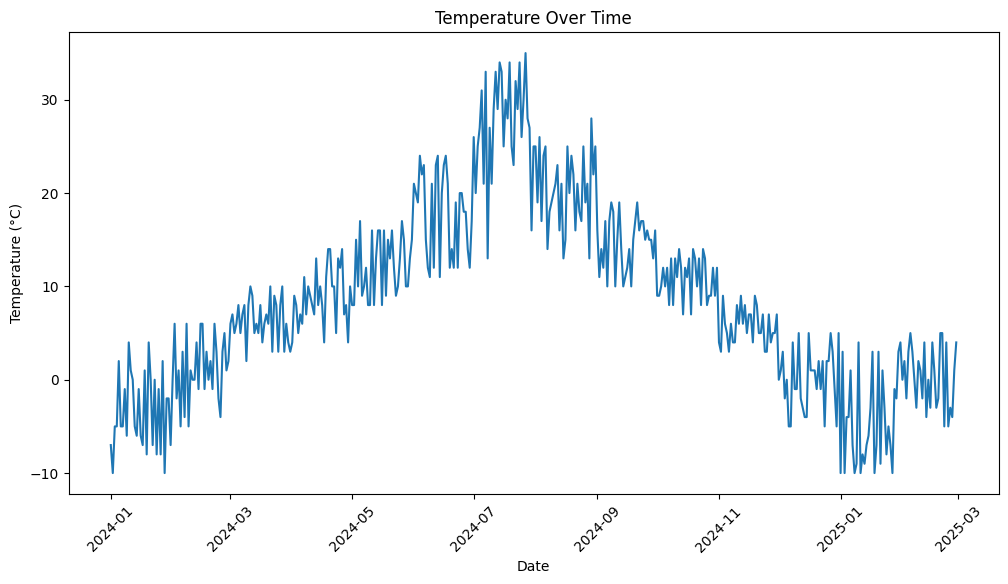

In [17]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='temperature', data=dummy_df)
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

# Start creating dummy data

## Create rain

In [18]:
# Initialize the rain column with zeros
dummy_df['rain'] = 0

# Iterate over each month in the date range
for month in scope_table_df['Month']:
    # Get the number of rain days for the current month
    rain_days = scope_table_df.loc[scope_table_df['Month'] == month, 'Rain Days'].values[0]
    
    # Get all the dates for the current month
    month_dates = dummy_df[dummy_df['date'].dt.strftime('%B') == month]
    
    # Randomly select dates for rain
    rain_dates = np.random.choice(month_dates.index, size=rain_days, replace=False)
    
    # Set the rain column to 1 for the selected dates
    dummy_df.loc[rain_dates, 'rain'] = 1

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain
0,2024-01-01,-7,Jan,Winter,0
1,2024-01-02,-10,Jan,Winter,0
2,2024-01-03,-5,Jan,Winter,0
3,2024-01-04,-5,Jan,Winter,0
4,2024-01-05,2,Jan,Winter,0


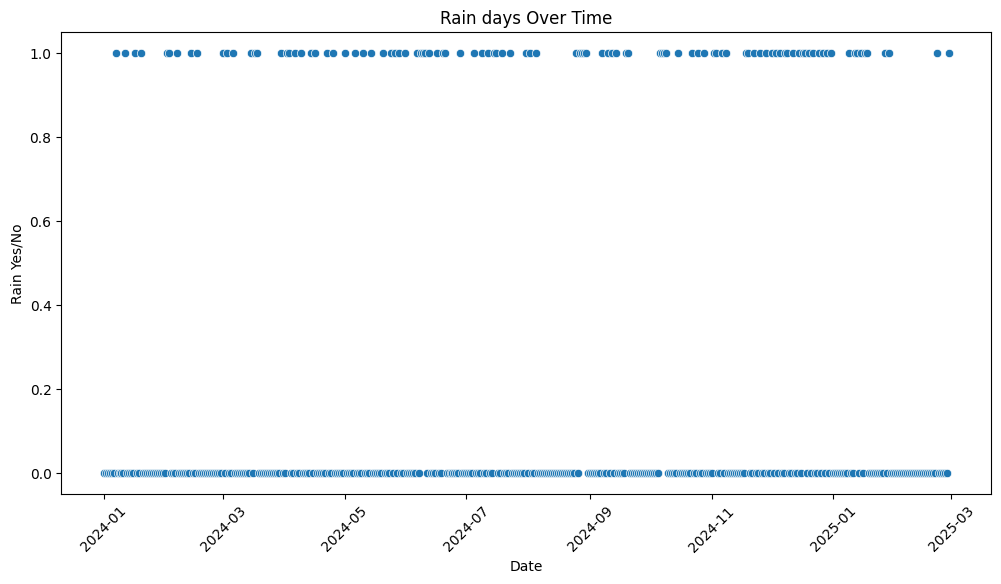

In [19]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='rain', data=dummy_df)
plt.title('Rain days Over Time')
plt.xlabel('Date')
plt.ylabel('Rain Yes/No')
plt.xticks(rotation=45)
plt.show()

## Create sunlight

In [20]:
# Create the sunlight column based on the rain column
dummy_df['sunlight'] = dummy_df['rain'].apply(lambda x: 0 if x == 1 else 1)

# Display the updated DataFrame
dummy_df.describe()

,date,temperature,rain,sunlight
count,425,425.000000,425.000000,425.000000
mean,2024-07-30 23:59:59.999999744,8.461176,0.247059,0.752941
min,2024-01-01 00:00:00,-10.000000,0.000000,0.000000
25%,2024-04-16 00:00:00,2.000000,0.000000,1.000000
50%,2024-07-31 00:00:00,8.000000,0.000000,1.000000
75%,2024-11-14 00:00:00,15.000000,0.000000,1.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000
std,NaN,9.804650,0.431810,0.431810


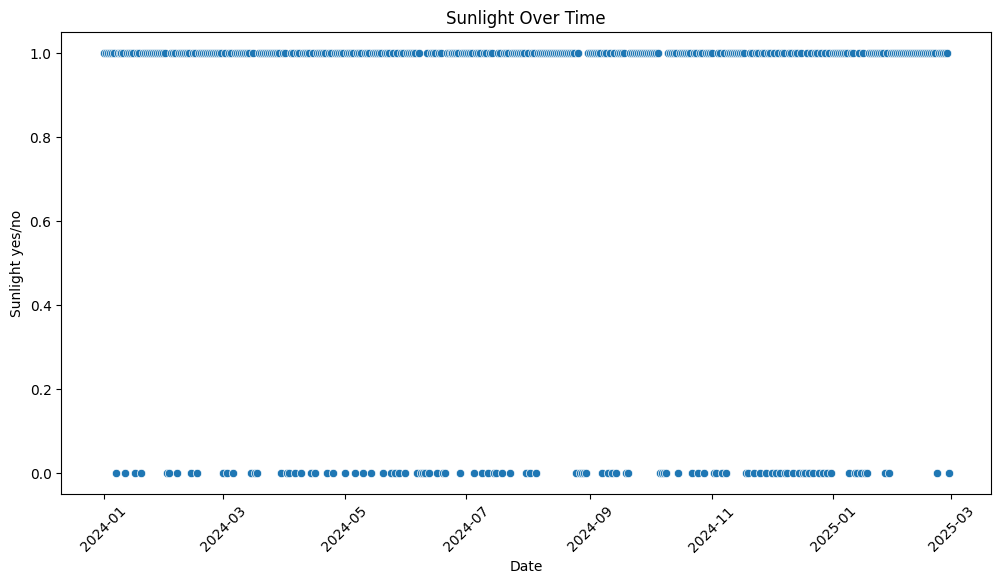

In [21]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='sunlight', data=dummy_df)
plt.title('Sunlight Over Time')
plt.xlabel('Date')
plt.ylabel('Sunlight yes/no')
plt.xticks(rotation=45)
plt.show()

## create wind

In [22]:
# Create the wind column based on the rain & temperature
dummy_df['wind'] = dummy_df.apply(lambda row: np.random.randint(15, 26) 
                                  if row['rain'] == 1 else np.random.randint(0, 6), axis=1)

dummy_df['wind'] = dummy_df.apply(lambda row: row['wind'] + np.random.randint(10, 16) 
                                  if row['temperature'] <= 10 else row['wind'] + np.random.randint(0, 6), axis=1)

dummy_df.describe()

,date,temperature,rain,sunlight,wind
count,425,425.000000,425.000000,425.000000,425.000000
mean,2024-07-30 23:59:59.999999744,8.461176,0.247059,0.752941,15.392941
min,2024-01-01 00:00:00,-10.000000,0.000000,0.000000,0.000000
25%,2024-04-16 00:00:00,2.000000,0.000000,1.000000,8.000000
50%,2024-07-31 00:00:00,8.000000,0.000000,1.000000,14.000000
75%,2024-11-14 00:00:00,15.000000,0.000000,1.000000,19.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000,39.000000
std,NaN,9.804650,0.431810,0.431810,9.406363


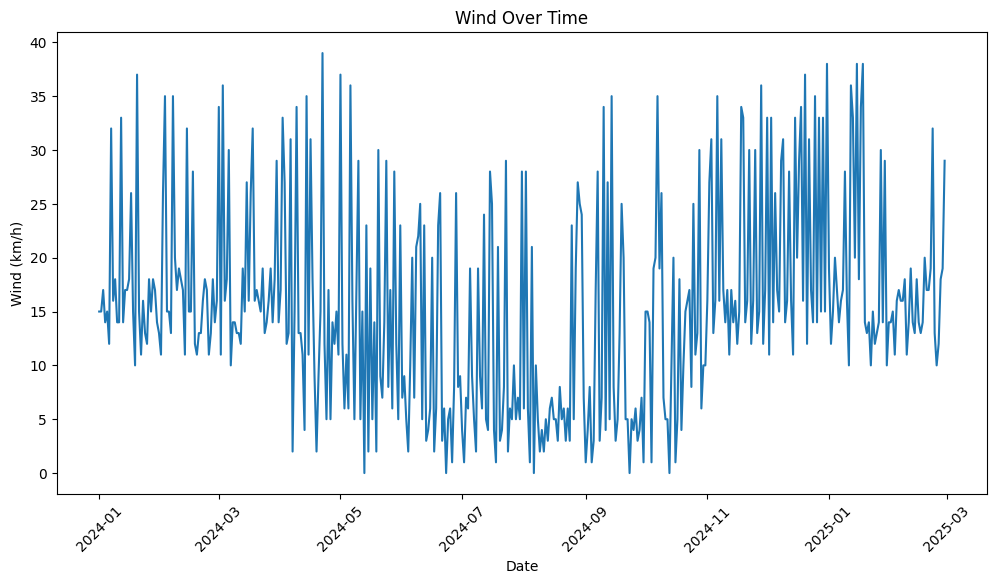

In [23]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='wind', data=dummy_df)
plt.title('Wind Over Time')
plt.xlabel('Date')
plt.ylabel('Wind (km/h)')
plt.xticks(rotation=45)
plt.show()

## Create mood

In [24]:
# Create the mood column and populate it with 0
dummy_df['mood'] = 0

# modify mood based on rain days
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] - np.random.randint(10, 21)
                                  if row['rain'] == 1 else row['mood'] + np.random.randint(10, 21), axis=1)

# modify mood based on temperature
# cold weather
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] - np.random.randint(10, 21) 
                                  if row['temperature'] <= 10 else row['mood'] + np.random.randint(10, 21), axis=1)

# hot weather
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] - np.random.randint(10, 21) 
                                  if row['temperature'] > 20 else row['mood'] + 0, axis=1)

# modify mood based on wind
dummy_df['mood'] = dummy_df.apply(lambda row: row['mood'] - np.random.randint(10, 21) 
                                  if row['wind'] >= 10 else row['mood'] + np.random.randint(10, 21), axis=1)

# Display the updated DataFrame
dummy_df.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood
0,2024-01-01,-7,Jan,Winter,0,1,15,-25
1,2024-01-02,-10,Jan,Winter,0,1,15,-14
2,2024-01-03,-5,Jan,Winter,0,1,17,-12
3,2024-01-04,-5,Jan,Winter,0,1,14,-14
4,2024-01-05,2,Jan,Winter,0,1,15,-19


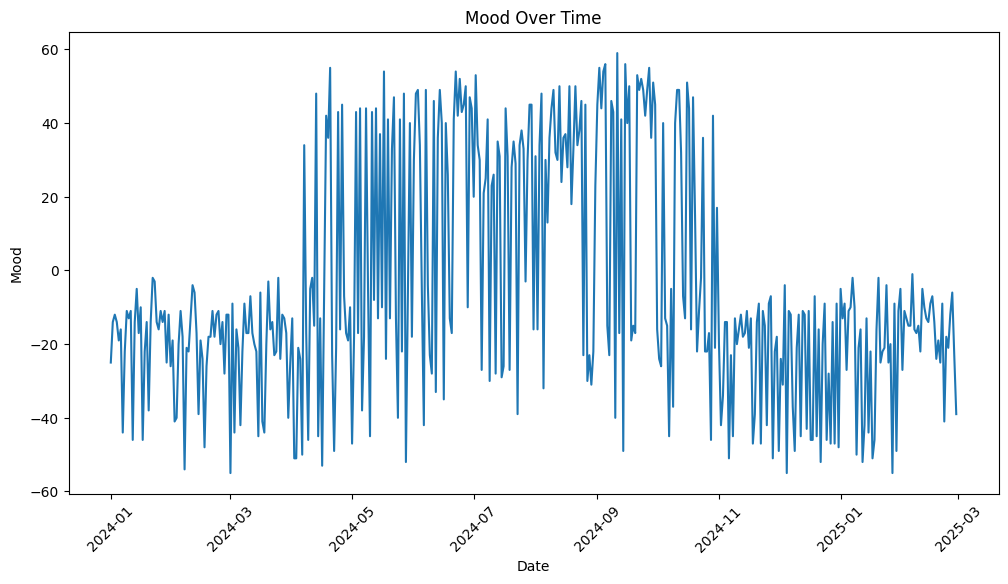

In [25]:
# Create a line plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='mood', data=dummy_df)
plt.title('Mood Over Time')
plt.xlabel('Date')
plt.ylabel('Mood')
plt.xticks(rotation=45)
plt.show()

## Create Walk

In [26]:
# Create the sunlight column based on the rain column
dummy_df['walk'] = 0

for index, row in dummy_df.iterrows():
    if row['mood'] <= -40:
        dummy_df.at[index, 'walk'] = 0
    elif row['mood'] > -40 and row['mood'] <= 0:
        dummy_df.at[index, 'walk'] = np.random.randint(0, 2)
    elif row['mood'] > 0:
        dummy_df.at[index, 'walk'] = 1

dummy_df.describe()

,date,temperature,rain,sunlight,wind,mood,walk
count,425,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,2024-07-30 23:59:59.999999744,8.461176,0.247059,0.752941,15.392941,-4.642353,0.567059
min,2024-01-01 00:00:00,-10.000000,0.000000,0.000000,0.000000,-55.000000,0.000000
25%,2024-04-16 00:00:00,2.000000,0.000000,1.000000,8.000000,-23.000000,0.000000
50%,2024-07-31 00:00:00,8.000000,0.000000,1.000000,14.000000,-13.000000,1.000000
75%,2024-11-14 00:00:00,15.000000,0.000000,1.000000,19.000000,28.000000,1.000000
max,2025-02-28 00:00:00,35.000000,1.000000,1.000000,39.000000,59.000000,1.000000
std,NaN,9.804650,0.431810,0.431810,9.406363,31.135872,0.496067


# Export Data

## EDA

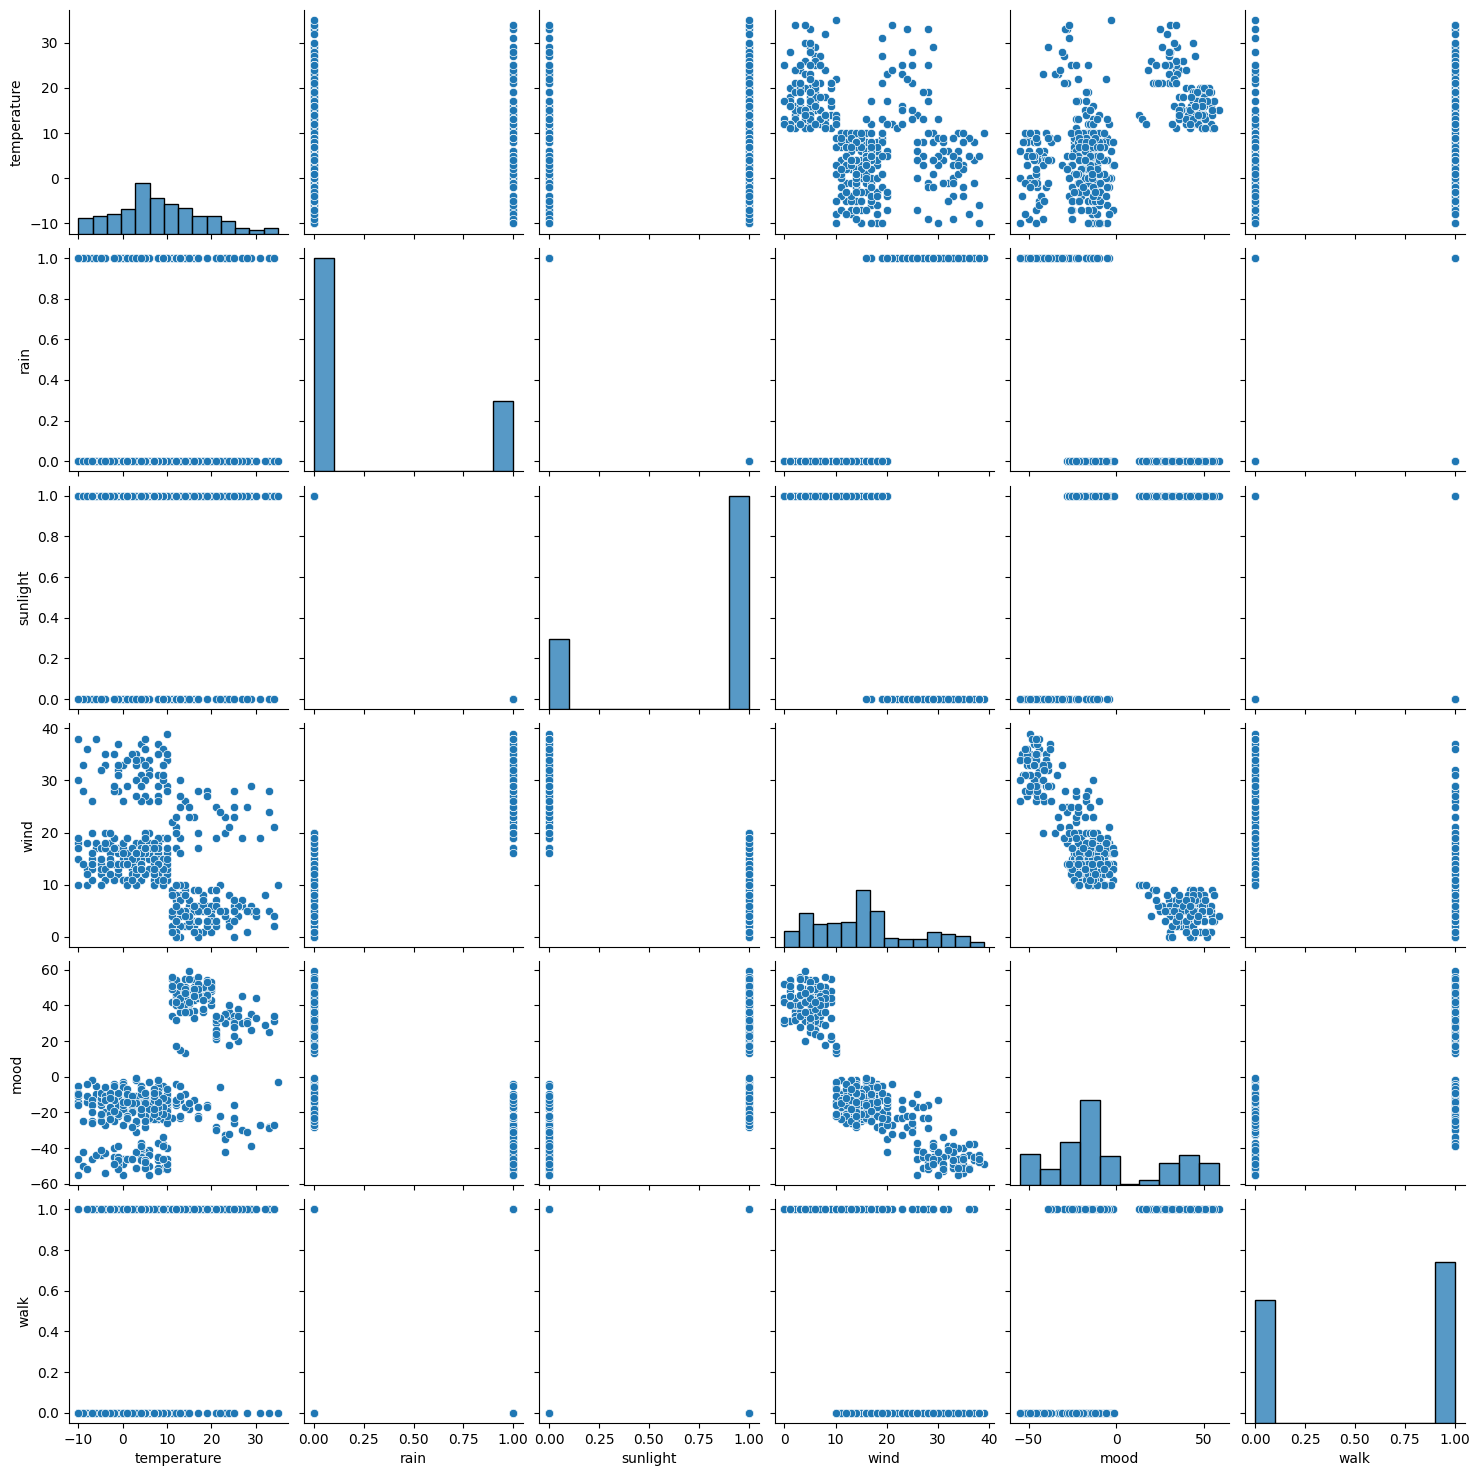

In [27]:
# Create a pair plot using seaborn
sns.pairplot(dummy_df)
plt.savefig('./images/pairs_plot_plain.png')
plt.show()

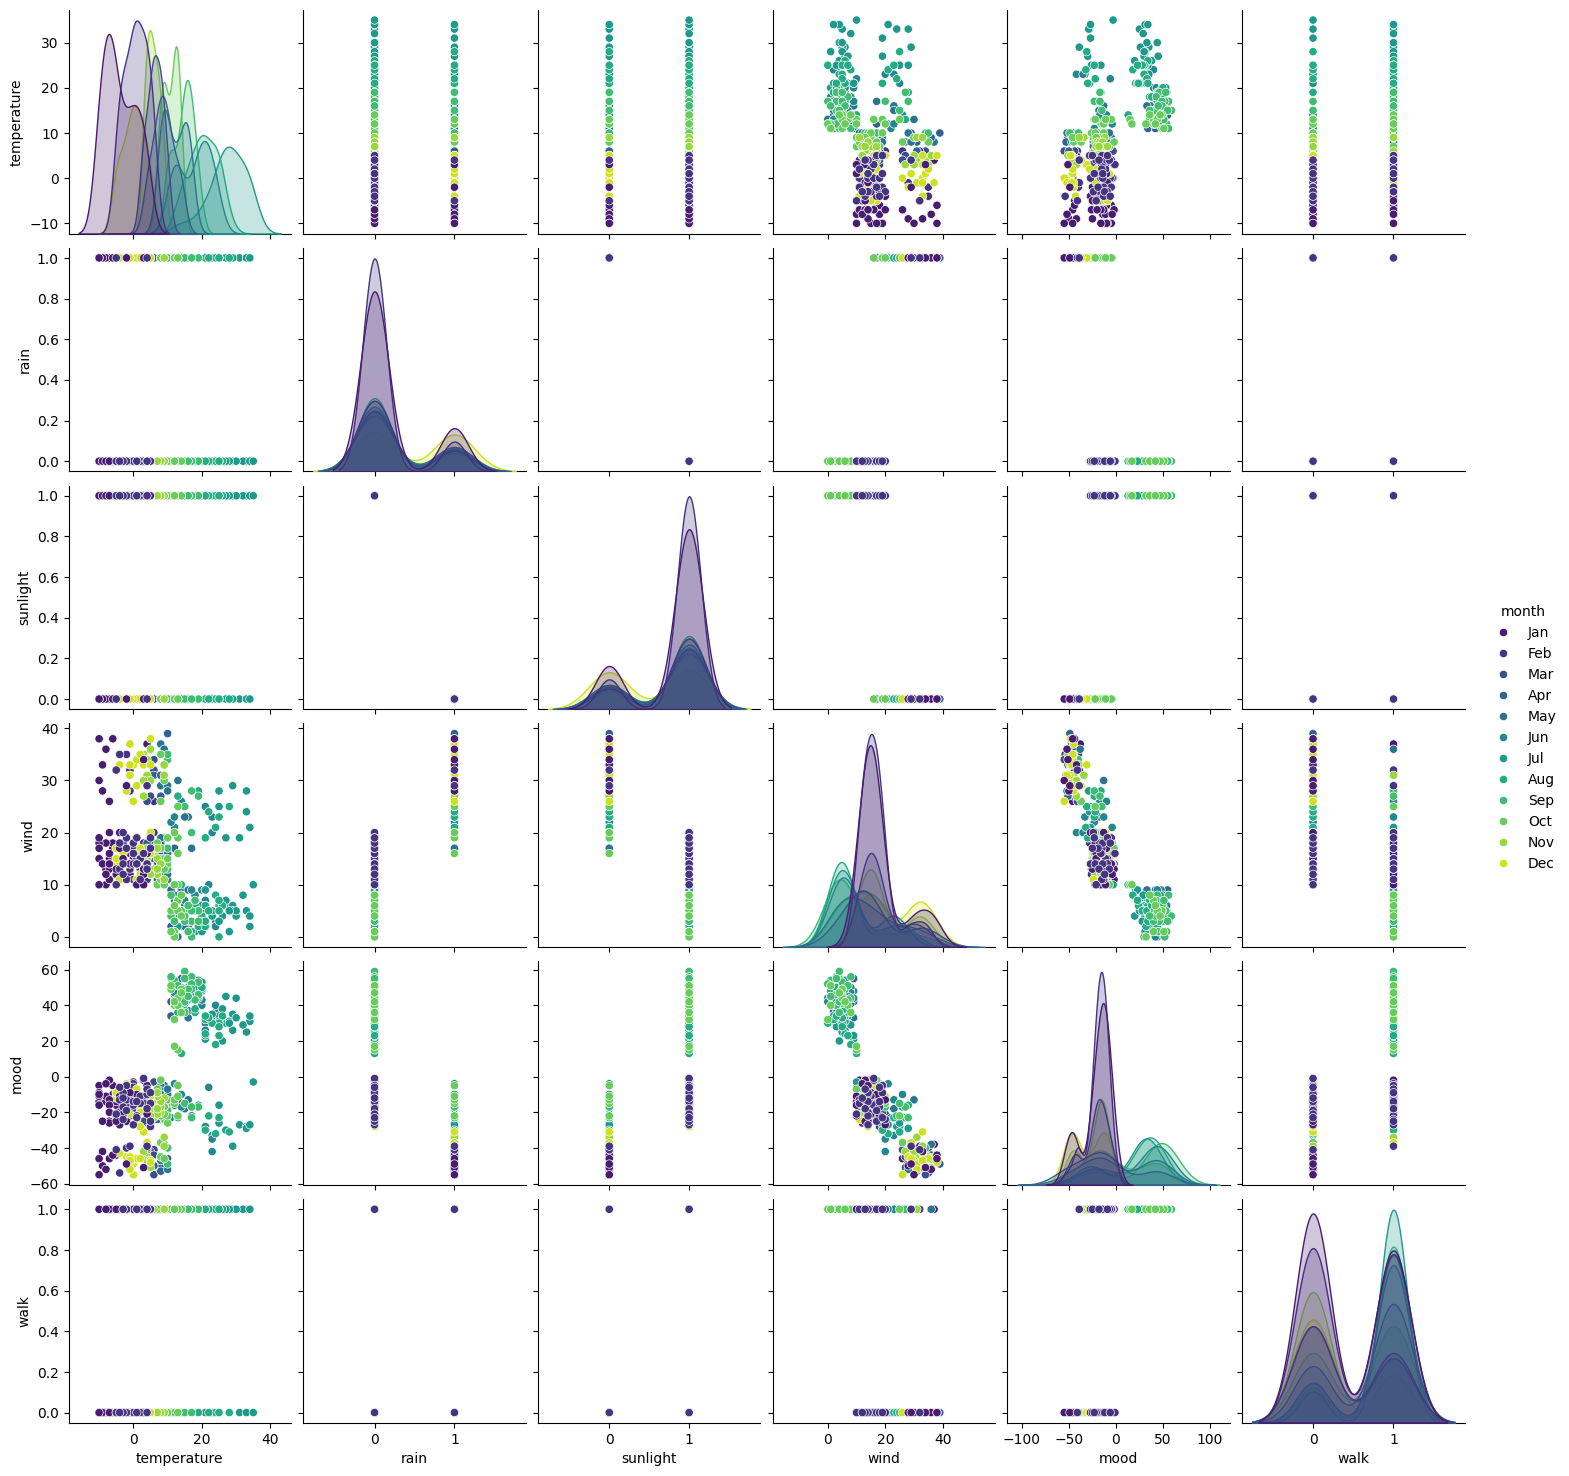

In [28]:
# Create a pair plot using seaborn
sns.pairplot(dummy_df, hue='month', palette='viridis')
plt.savefig('./images/pairs_plot_months.png')
plt.show()

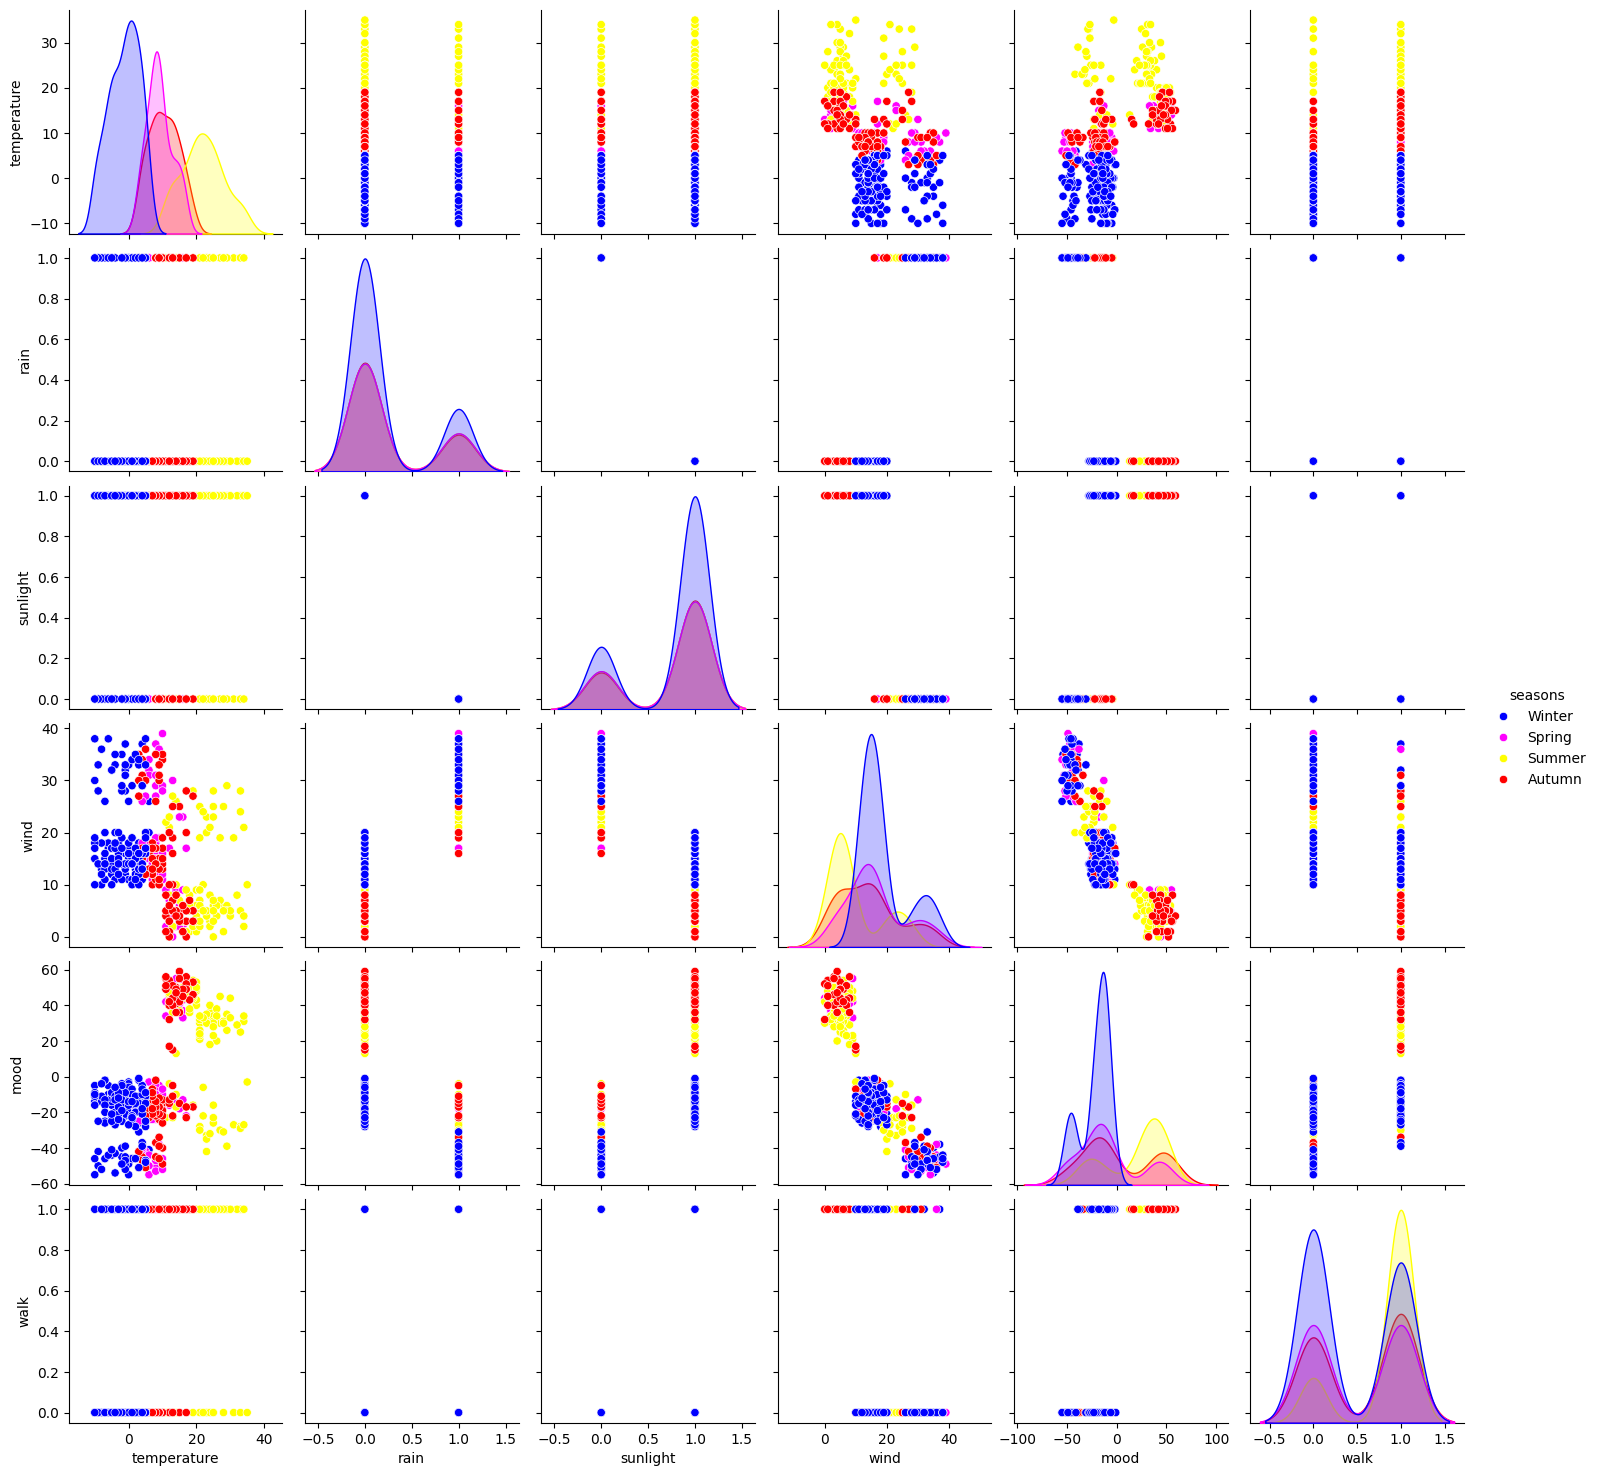

In [36]:
# Create a pair plot using seaborn
custom_palette = {'Winter': 'blue', 'Autumn': 'red', 'Summer': 'yellow', 'Spring': 'magenta'}
sns.pairplot(dummy_df, hue='seasons', palette=custom_palette)
plt.savefig('./images/pairs_plot_seasons.png')
plt.show()

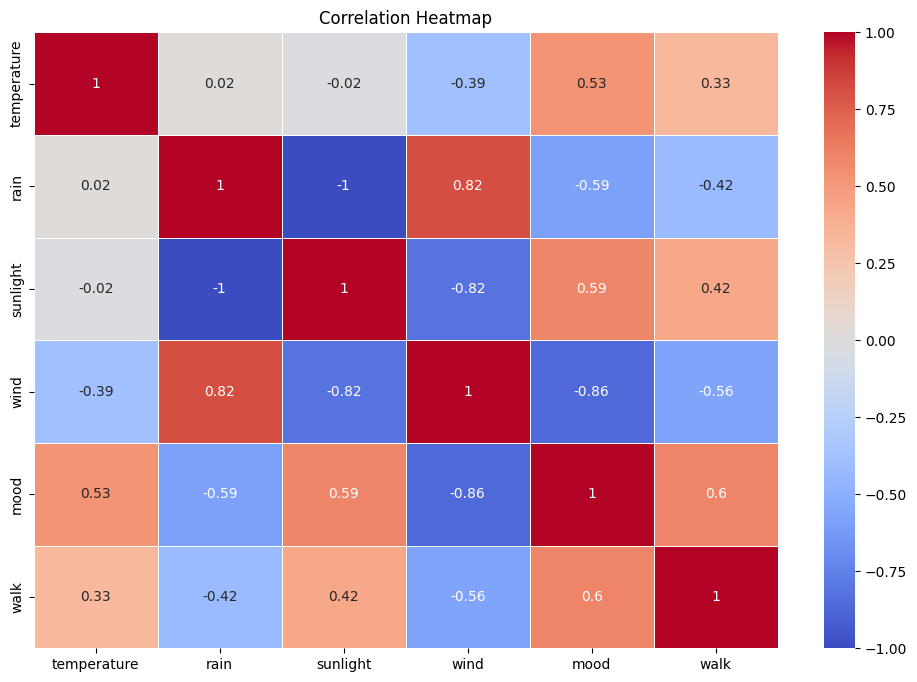

In [30]:
# Select only numeric columns for correlation matrix calculation
numeric_df = dummy_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('./images/corrs_plot.png')
plt.show()

export as csv

In [31]:
# Export the dummy_df DataFrame to a CSV file
dummy_df.to_csv('./data/dummy_data.csv', index=False)

# Add New data

In [32]:
# Filter the data for March 2024
march_2024_data = dummy_df[dummy_df['date'].dt.strftime('%Y-%m') == '2024-03'].copy()

# Update the date to March 2025
march_2024_data['date'] = march_2024_data['date'] + pd.DateOffset(years=1)

# make a list of DataFrames to join
df_list = [dummy_df, march_2024_data]

# Append the new data to dummy_df
dummy_df_updated = pd.concat(df_list)

# Display the updated DataFrame
dummy_df_updated.tail()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk
86,2025-03-27,10,Mar,Spring,0,1,19,-12,0
87,2025-03-28,3,Mar,Spring,0,1,14,-13,0
88,2025-03-29,6,Mar,Spring,0,1,18,-17,1
89,2025-03-30,4,Mar,Spring,1,0,29,-40,0
90,2025-03-31,3,Mar,Spring,0,1,14,-25,0


In [33]:
march_2024_data.head()

,date,temperature,month,seasons,rain,sunlight,wind,mood,walk
60,2025-03-01,6,Mar,Spring,1,0,34,-55,0
61,2025-03-02,7,Mar,Spring,0,1,11,-9,1
62,2025-03-03,5,Mar,Spring,1,0,36,-44,0
63,2025-03-04,6,Mar,Spring,0,1,16,-16,1
64,2025-03-05,8,Mar,Spring,0,1,18,-21,0


export the new data

In [34]:
# export the joined data to a csv
dummy_df_updated.to_csv('./data/to_predict_long.csv', index=False)

# Export the march_2024_data DataFrame to a CSV file
march_2024_data.to_csv('./data/to_predict_short.csv', index=False)

plot the data for 2 years march

In [35]:
dummy_df.info()
dummy_df_updated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         425 non-null    datetime64[ns]
 1   temperature  425 non-null    int64         
 2   month        425 non-null    object        
 3   seasons      425 non-null    object        
 4   rain         425 non-null    int64         
 5   sunlight     425 non-null    int64         
 6   wind         425 non-null    int64         
 7   mood         425 non-null    int64         
 8   walk         425 non-null    int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 30.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 90
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         456 non-null    datetime64[ns]
 1   temperature  456 non-null    int64   